In [2]:
%matplotlib inline

import numpy as np
import pandas as pd

from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.decomposition import SparsePCA
from sklearn.mixture import GaussianMixture as GMM
from matplotlib.colors import ListedColormap
from sklearn.model_selection import GridSearchCV

import time

import warnings
warnings.filterwarnings('ignore')

np.set_printoptions(suppress=True, linewidth=1000, precision=9)
np.random.seed(0)

In [3]:
# Binarize Y
def binarizeY(data):
    binarized_data = np.zeros((data.size,10))
    for j in range(0,data.size):
        feature = data[j:j+1]
        i = feature.astype(np.int64) 
        binarized_data[j,i]=1
    return binarized_data

# train_dev_Y_bi = binarizeY(train_dev_Y)

In [4]:
def binarized_X_dim_reduce(n_comp=1, binaryzed_data=None):
    # Soil PCA section

    pca_fl = ['pca_'+str(i+1) for i in range(n_comp)]
    pca_mod = PCA(n_components = n_comp)
    pca_data = pca_mod.fit_transform(binaryzed_data)
    
        
    return pca_data, pca_fl
    

In [5]:
def prep_fc_X_data(fc_X):
    # Pull out the features to normalize
    fc_X_norm_feat_list = [
        'Elevation',
        'Aspect',
        'Slope',
        'Horizontal_Distance_To_Hydrology',
        'Vertical_Distance_To_Hydrology',
        'Horizontal_Distance_To_Roadways',
        'Hillshade_9am',
        'Hillshade_Noon',
        'Hillshade_3pm',
        'Horizontal_Distance_To_Fire_Points'
    ]

    fc_X_norm = np.array(fc_X[fc_X_norm_feat_list])

    # print(treedata_X_norm[0,:])

    normer = preprocessing.StandardScaler()

    fc_X_norm = normer.fit_transform(fc_X_norm)

    # print(train_dev_X_norm[0,:])


    # Pull out the wilderness area features
    fc_X_wild_feat_list = [
        'Wilderness_Area1', 'Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4'
    ]

    fc_X_wild = np.array(fc_X[fc_X_wild_feat_list])


    # Pull out the soil area features
    fc_X_soil_feat_list = [
        'Soil_Type1', 'Soil_Type2', 'Soil_Type3', 'Soil_Type4', 'Soil_Type5', 'Soil_Type6', 'Soil_Type7', 'Soil_Type8',
        'Soil_Type9', 'Soil_Type10', 'Soil_Type11', 'Soil_Type12', 'Soil_Type13', 'Soil_Type14', 'Soil_Type15', 'Soil_Type16',
        'Soil_Type17', 'Soil_Type18', 'Soil_Type19', 'Soil_Type20', 'Soil_Type21', 'Soil_Type22', 'Soil_Type23', 'Soil_Type24',
        'Soil_Type25', 'Soil_Type26', 'Soil_Type27', 'Soil_Type28', 'Soil_Type29', 'Soil_Type30', 'Soil_Type31', 'Soil_Type32',
        'Soil_Type33', 'Soil_Type34', 'Soil_Type35', 'Soil_Type36', 'Soil_Type37', 'Soil_Type38', 'Soil_Type39', 'Soil_Type40'
    ]

    fc_X_soil = np.array(fc_X[fc_X_soil_feat_list])

    fc_X_soil, fc_X_soil_feat_list = binarized_X_dim_reduce(n_comp=1, binaryzed_data=fc_X_soil)


    # Choose features 
    fc_X_feat_list = fc_X_norm_feat_list + fc_X_wild_feat_list + fc_X_soil_feat_list
    # print(feature_list)
    # Stich together the normalized and binarized features
    fc_X = np.concatenate((fc_X_norm, fc_X_wild, fc_X_soil), axis=1)
    # print(train_dev_X[0,:])

    return np.array(fc_X), fc_X_feat_list



In [6]:
train_dev = pd.read_csv("../data/train.csv", index_col=0)
n = train_dev.shape[0]

# How much do you want in dev?
percent_in_dev = .2 
dev_slice = int(percent_in_dev * n)

# shuffle the df
train_dev = train_dev.sample(frac=1).reset_index(drop=True)

# split
dev = train_dev[:dev_slice]
train = train_dev[dev_slice:]

n_dev = dev.shape[0]
n_train = train.shape[0]
n_feat = train.shape[1]

In [7]:
train_Y = np.array(np.array(train["Cover_Type"].tolist()))
dev_Y = np.array(np.array(dev["Cover_Type"].tolist()))

train_X, train_X_fl = prep_fc_X_data(train)
dev_X, dev_X_fl = prep_fc_X_data(dev)

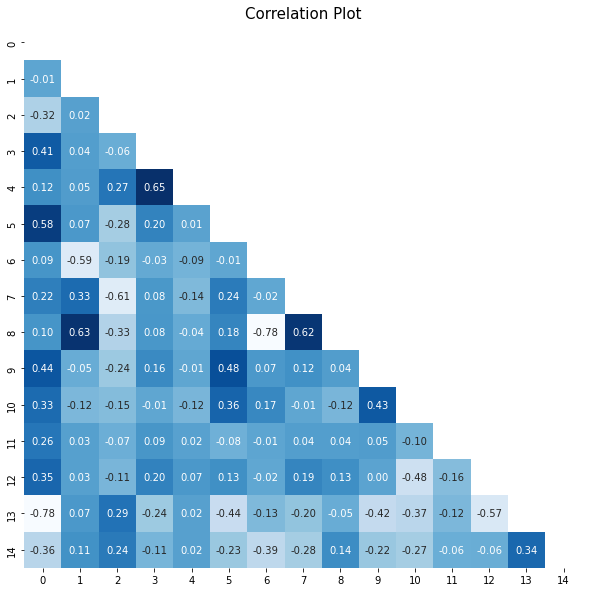

In [13]:
# correlation plot
corr = pd.DataFrame(train_X).corr()

# make mask (only plot lower left triangle)
mask = np.ones_like(corr,dtype = np.bool)
mask = np.triu(mask)

# plot the heatmap
fig, ax = plt.subplots(figsize=(10,10))         
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns,
        mask = mask,
        annot=True, 
        fmt='.2f',
        cmap="Blues",
        cbar=False)

plt.title('Correlation Plot',size=15)
plt.show()
pass

accuracy: 0.7700892725974466
best parameters:
{'n_neighbors': 1}


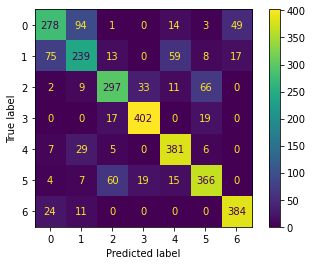

In [15]:
def knn_search(train_dat=train_X, train_lab=train_Y, dev_dat=dev_X, dev_lab=dev_Y):
    parameters = {
        'n_neighbors': [1,2,3,4,5]
    }

    knn = KNeighborsClassifier()

    knn_gs = GridSearchCV(knn, parameters, n_jobs=-1).fit(train_dat, train_lab)

    print(f'accuracy: {knn_gs.best_score_}')
    print(f'best parameters:\n{knn_gs.best_params_}')

    knn_pred = knn_gs.best_estimator_.predict(dev_dat).astype(int)

    cm = confusion_matrix(dev_lab, knn_pred)

    ConfusionMatrixDisplay(cm).plot()

knn_search()

KNN accuracy with no filtering: 0.7761243386243386 for k = 1


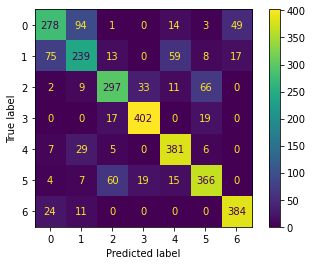

In [16]:
def knn(n_neighbors=1, train_dat=train_X, train_lab=train_Y, dev_dat=dev_X, dev_lab=dev_Y):
    
    knn = KNeighborsClassifier(n_neighbors=n_neighbors)

    knn.fit(train_dat, train_lab) #train on processed train data

    pred_knn  = knn.predict(dev_dat) #predict on dev data

    accuracy_count_knn = 0

    for j in range(pred_knn.shape[0]):
        if pred_knn[j] == dev_lab[j]:
            accuracy_count_knn += 1
        else:
            continue

    print(f"KNN accuracy with no filtering: {accuracy_count_knn/pred_knn.shape[0]} for k = {n_neighbors}")

    cm = confusion_matrix(dev_lab, pred_knn)

    ConfusionMatrixDisplay(cm).plot()

    pd.DataFrame(classification_report(dev_lab, pred_knn, output_dict=True))

knn(n_neighbors=1)

GaussianNB accuracy w/ var smoothing @ .1: 0.5830026455026455


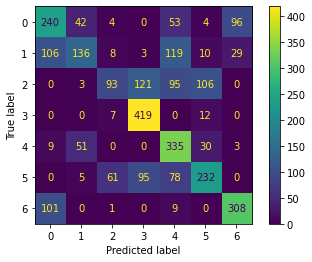

In [17]:
def gaussian_nb(train_dat=train_X, train_lab=train_Y, dev_dat=dev_X, dev_lab=dev_Y):

    ###Train on gaussianNB with var_smoothing = .1###

    model_gnb_s = GaussianNB(var_smoothing=.1)
    model_gnb_s.fit(train_dat,train_lab)

    sigmas2 = model_gnb_s.sigma_
    thetas2 = model_gnb_s.theta_

    ## predict on dev data

    pred_gnb_s = model_gnb_s.predict(dev_dat)
    accuracy_count_gnb_s = 0


    ###generate accuracy
    for j in range(dev_lab.shape[0]):
        if pred_gnb_s[j] == dev_lab[j]:
            accuracy_count_gnb_s += 1
        else:
            continue

    print("GaussianNB accuracy w/ var smoothing @ .1: " + str(accuracy_count_gnb_s/pred_gnb_s.shape[0]))

    cm = confusion_matrix(dev_lab, pred_gnb_s)

    ConfusionMatrixDisplay(cm).plot()

    pd.DataFrame(classification_report(dev_lab, pred_gnb_s, output_dict=True))


    
gaussian_nb()

accuracy: 0.8566465891581455
best parameters:
{'criterion': 'entropy', 'max_depth': 19, 'max_features': 'log2', 'n_estimators': 500}


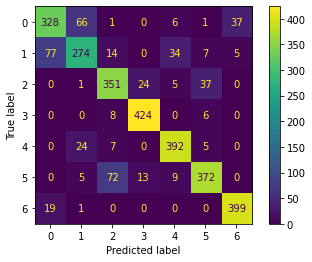

In [8]:
def rf_search(train_dat=train_X, train_lab=train_Y, dev_dat=dev_X, dev_lab=dev_Y):
    parameters = {
        'n_estimators': [500],
        'max_features': ['auto', 'sqrt', 'log2'],
        'max_depth' : [10,11,12,13,14,15,16,17,18,19,20],
        'criterion' :['gini', 'entropy']
    }

    rf = RandomForestClassifier()

    rf_gs = GridSearchCV(rf, parameters, n_jobs=-1).fit(train_dat, train_lab)

    print(f'accuracy: {rf_gs.best_score_}')
    print(f'best parameters:\n{rf_gs.best_params_}')

    rf_pred = rf_gs.best_estimator_.predict(dev_dat).astype(int)

    cm = confusion_matrix(dev_lab, rf_pred)

    ConfusionMatrixDisplay(cm).plot()

rf_search()

Train time = 1.8249993324279785
Predict time = 0.3119995594024658
Random Forest accuracy: 0.8373015873015873


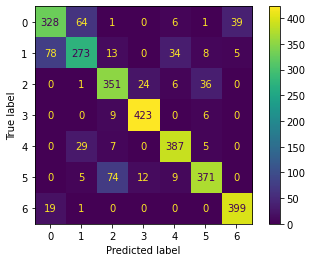

In [10]:
def randomforest(train_dat=train_X, train_lab=train_Y, dev_dat=dev_X, dev_lab=dev_Y):

    rf = RandomForestClassifier(
        n_estimators = 1000,
        criterion="entropy",
        max_depth=19,
        max_features= 'log2',
        n_jobs=-1)

    start_time = time.time()
    rf.fit(train_dat, train_lab)
    print(f'Train time = {time.time() - start_time}')

    start_time = time.time()
    rf_pred = rf.predict(dev_dat).astype(int)
    print(f'Predict time = {time.time() - start_time}')

    ###generate accuracy
    accuracy_count_rf = 0
    for j in range(dev_lab.shape[0]):
        if rf_pred[j] == dev_lab[j]:
            accuracy_count_rf += 1
        else:
            continue

    print("Random Forest accuracy: " + str(accuracy_count_rf/rf_pred.shape[0]))

    cm = confusion_matrix(dev_lab, rf_pred)

    ConfusionMatrixDisplay(cm).plot()

    pd.DataFrame(classification_report(dev_lab, rf_pred, output_dict=True))

randomforest()